# 1 寻解算法
## 1.1 正态方程

In [1]:
import numpy as np 
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

X_b = np.c_[np.ones((100, 1)), X]

theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) # 由于np.linalg.inv只能处理方阵
theta_best

array([[3.9903822 ],
       [3.02402786]])

In [2]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X,y)
print('W:%s,b:%s.'%(lr.intercept_,lr.coef_))

W:[4.09638288],b:[[2.90297259]].


## 1.2 梯度下降
- 幸运的是线性回归模型的均方差损失函数是一个凸函数，这意味着如果你选择曲线上的任意两点，它们的连线段不会与曲线发生交叉（译者注：该线段不会与曲线有第三个交点）。这意味着这个损失函数没有局部最小值，仅仅只有一个全局最小值。同时它也是一个斜率不能突变的连续函数。这两个因素导致了一个好的结果：梯度下降可以无限接近全局最小值。（只要你训练时间足够长，同时学习率不是太大 ）。
- 当我们使用梯度下降的时候，应该确保所有的特征有着相近的尺度范围（例如：使用 Scikit Learn 的 StandardScaler类），否则它将需要很长的时间才能够收敛。

In [10]:
n = 100
eta = 0.1
n_iterations = 1000
theta = np.random.randn(2,1) # 随机初始化系数矩阵:具有标准正态分布的行*列矩阵
for iteration in range(n_iterations):
    loss = 0.5 * 1/n * sum((X_b.dot(theta) - y) **2)
    if iteration % 100 == 0:
        print('iteration:%s,loss:%s,W:%s,b:%s.' % (iteration,loss.round(2),theta[0].round(2),theta[1].round(2)))
    gradient = 1/n * (X_b.T.dot((X_b.dot(theta) - y)))
    theta = theta - eta * gradient

iteration:0,loss:[45.99],W:[-2.03],b:[-0.51].
iteration:100,loss:[0.55],W:[3.74],b:[3.22].
iteration:200,loss:[0.53],W:[4.02],b:[2.97].
iteration:300,loss:[0.53],W:[4.08],b:[2.92].
iteration:400,loss:[0.53],W:[4.09],b:[2.91].
iteration:500,loss:[0.53],W:[4.1],b:[2.9].
iteration:600,loss:[0.53],W:[4.1],b:[2.9].
iteration:700,loss:[0.53],W:[4.1],b:[2.9].
iteration:800,loss:[0.53],W:[4.1],b:[2.9].
iteration:900,loss:[0.53],W:[4.1],b:[2.9].


## 1.3 随机梯度下降
- 每步的梯度计算上只随机选取训练集中的一个样本，损失函数会忽高忽低，大体上呈下降趋势。随着时间的推移，它会非常的靠近最小值，但是它不会停止在一个值上，它会一直在这个值附近摆动，因此，当算法停止的时候，最后的参数还不错，但不是最优值。
- 随机梯度下降算法能够跳过局部最小值。因此，随机梯度下降在寻找全局最小值上比批量梯度下降表现要好。
- 虽然随机性可以很好的跳过局部最优值，但同时它却不能达到最小值，解决这个难题的一个办法是逐渐降低学习率。 开始时，走的每一步较大，然后变得越来越小，从而使算法到达全局最小值。 这个过程被称为模拟退火。

In [20]:
n = 100
n_epochs = 50
theta = np.random.randn(2,1)

def learning_schedule(step):
    return 5/(50 + step)

for epoch in range(n_epochs):
    for i in range(n):
        random_inx = np.random.randint(0,n+1)
        X_b_sample = X_b[random_inx:random_inx+1]
        y_sample = y[random_inx:random_inx+1]
        gradient = X_b_sample.T.dot((X_b_sample.dot(theta) - y_sample)) # 每次只选取1条记录
        theta = theta - learning_schedule(epoch * n + i) * gradient # learning_schedule 替代 eta
        loss = 0.5 * sum((X_b_sample.dot(theta) - y_sample) **2)
    if epoch % 5 == 0:
        print('epoch:%s,loss:%s,W:%s,b:%s.' % (epoch,loss.round(2),theta[0].round(2),theta[1].round(2)))

epoch:0,loss:[0.01],W:[3.73],b:[3.21].
epoch:5,loss:[0.03],W:[3.89],b:[3.1].
epoch:10,loss:[0.34],W:[4.],b:[3.08].
epoch:15,loss:[0.81],W:[3.94],b:[3.01].
epoch:20,loss:[0.35],W:[3.99],b:[3.02].
epoch:25,loss:[0.34],W:[3.95],b:[2.95].
epoch:30,loss:[0.07],W:[4.],b:[3.].
epoch:35,loss:[0.06],W:[4.04],b:[2.97].
epoch:40,loss:[0.16],W:[4.05],b:[2.94].
epoch:45,loss:[0.03],W:[4.07],b:[2.95].


由于每个实例的选择是随机的，有的实例可能在每一代中都被选到，这样其他的实例也可能一直不被选到。如果你想保证每一代迭代过程，算法可以遍历所有实例，一种方法是将训练集打乱重排，然后选择一个实例，之后再继续打乱重排，以此类推一直进行下去。但是这样收敛速度会非常的慢。

**Scikit-Learn** 线性回归的随机梯度下降:

In [32]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50,
                       learning_rate='constant', # constant，optimal，invscaling
                       eta0=0.1,
                       penalty=None, # 正则项 
                       random_state=7)
sgd_reg.fit(X,y.ravel()) # y 转换成 1*n
print('W:%s,b:%s.'%(sgd_reg.intercept_,sgd_reg.coef_))

W:[4.19072373],b:[2.78582493].


## 1.4 小批量梯度下降
在迭代的每一步，批量梯度使用整个训练集，随机梯度时候用仅仅一个实例，在小批量梯度下降中，它则使用一个随机的小型实例集。小批量梯度下降在参数空间上的表现比随机梯度下降要好的多，尤其在有大量的小型实例集时。作为结果，小批量梯度下降会比随机梯度更靠近最小值。但是，另一方面，它有可能陷在局部最小值中（在遇到局部最小值问题的情况下，和我们之前看到的线性回归不一样）。

# 2 多项式回归
## 2.1 多项式回归
- 生成非线性散点集合作为样例
- 数据预处理，衍生多项式特征宽表
- 基于衍生后的特征宽表进行回归建模

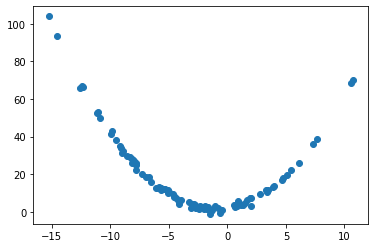

In [6]:
import numpy as np
import matplotlib.pyplot as plt

x = 6 * np.random.randn(100,1) - 3
y = 0.5 * x**2 + x + 2 + np.random.randn(100,1)
plt.scatter(x,y)

In [19]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2,
                                   interaction_only=False, # 仅交互项
                                   include_bias=False) # 截距项
x_poly = poly_features.fit_transform(x)
print('原始特征:%s\n新特征:%s' % (x[0],x_poly[0]))

原始特征:[-5.29902186]
新特征:[-5.29902186 28.07963265]


In [21]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_poly,y)
print('W:%s\nb:%s' % (lin_reg.coef_,lin_reg.intercept_))

W:[[0.98928081 0.50122411]]
b:[1.92115417]


<AxesSubplot:xlabel='x', ylabel='y'>

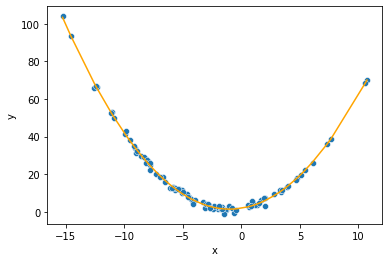

In [75]:
import seaborn as sns
from pandas import Series,DataFrame
y_pred = lin_reg.predict(x_poly)
df = DataFrame({'x':np.ravel(x),'y':np.ravel(y),'y_pred':np.ravel(y_pred)})
sns.scatterplot(x='x',y='y',data=df)
sns.lineplot(x='x',y='y_pred',data=df,color='orange')

# 学习曲线
通常，建模问题中我们并不知道数据的生成函数，也就无法了解特征中包含哪些多项式，但依然要评估模型的复杂度、过拟合/欠拟合情况。

模型的泛化误差：
1. 偏差：泛化误差的这部分误差是由于错误的假设决定的。例如实际是一个二次模型，你却假设了一个线性模型。一个高偏差的模型最容易出现欠拟合。
2. 方差：这部分误差是由于模型对训练数据的微小变化较为敏感，一个多自由度的模型更容易有高的方差（例如一个高阶多项式模型），因此会导致模型过拟合。
3. 不可约误差：这部分误差是由于数据本身的噪声决定的。降低这部分误差的唯一方法就是进行数据清洗（例如：修复数据源，修复坏的传感器，识别和剔除异常值）。

本节就讨论两种不错的方法：交叉验证&学习曲线。
## 交叉验证
如果模型在训练集上表现良好，通过交叉验证指标却得出其泛化能力很差，那么模型就是过拟合了；如果在这两方面都表现不好，那么就是欠拟合了。

## 学习曲线
1. 首先，绘制模型在**训练集**上的学习曲线，刚开始只有一两个样本的时候，模型能够非常好的拟合它们，这也是为什么曲线是从零开始的原因。但是当加入了一些新的样本的时候，训练集上的拟合程度变得难以接受，出现这种情况有两个原因，一是因为数据中含有噪声，另一个是数据根本不是线性的。因此随着数据规模的增大，误差也会一直增大，直到达到高原地带并趋于稳定，在之后，继续加入新的样本，模型的平均误差不会变得更好或者更差。
2. 其次绘制测试集学习曲线：当以非常少的样本去训练时，模型不能恰当的泛化，也就是为什么验证误差一开始是非常大的。当训练样本变多的时候，模型学习的东西变多，验证误差开始缓慢的下降。最后误差会到达在一个高原地带并趋于稳定
3. 通过评估最后训练集、测试集学习曲线接近程度、误差值来评估建模效果。

W:[[0.98379813 0.50104274]]
b:[1.91884996]


LinearRegression()

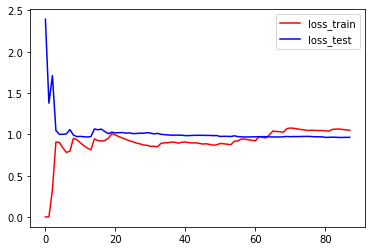

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

def Modeling(x,y):
    poly_features = PolynomialFeatures(degree=2,include_bias=False)
    x_poly = poly_features.fit_transform(x)
    x_train,x_test,y_train,y_test = train_test_split(x_poly,y,test_size=0.1,random_state=7)
    lin_reg = LinearRegression()
    loss_train,loss_test = [],[]
    for i in range(2,len(y_train)):
        lin_reg.fit(x_train[:i],y_train[:i])
        y_train_pred = lin_reg.predict(x_train[:i])
        y_test_pred = lin_reg.predict(x_test)
        loss_train.append(mean_squared_error(y_train_pred,y_train[:i]))
        loss_test.append(mean_squared_error(y_test_pred,y_test))
    plt.plot(np.sqrt(loss_train),'r',label='loss_train')
    plt.plot(np.sqrt(loss_test),'b',label='loss_test')
    plt.legend()
    print('W:%s\nb:%s' % (lin_reg.coef_,lin_reg.intercept_))
    return lin_reg

Modeling(x,y)

# 正则化
## Lasso 回归
损失函数：添加权重向量的$\ell_1$范数作为正则化项：
$$J(\theta) = MSE(\theta) + \alpha\displaystyle\sum^{n}_{i=1}|\theta_i|$$
其重要特征是倾向于完全消除最不重要的特征的权重（即将它们设置为零）。换句话说，Lasso回归自动的进行特征选择同时输出一个稀疏模型（即，具有很少的非零权重）。

In [129]:
import numpy as np 
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

X = 2 * np.random.rand(1000, 1)
y = 4 + 3 * X + np.random.randn(1000, 1)
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=7)
pipe = Pipeline([('scaler',MinMaxScaler()),
                 ('poly_features',PolynomialFeatures(degree=2,include_bias=False)),
                 ('lasso',Lasso(alpha=0.01,fit_intercept=True,random_state=7))])
pipe.fit(x_train,y_train)
mean_squared_error(y_test,pipe.predict(x_test))

0.9411480538902796

## 岭回归
岭回归（Tikhonov正则化）：线性回归的损失函数上叠加正则项：
$$J(\theta) = MSE(\theta) + \frac{\alpha}{2}\displaystyle\sum^{n}_{i=1}\theta_i^2$$
- 对输入特征敏感，需预处理（归一化等）。
- $\theta\to0$：未进行正则化。
- $\alpha\to0$：岭回归便变为了线性回归。
- $\alpha\to\infty$：$\theta_i\to0$，穿过数据平均值的水平直线。

In [116]:
import numpy as np 
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

X = 2 * np.random.rand(1000, 1)
y = 4 + 3 * X + np.random.randn(1000, 1)
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=7)
pipe = Pipeline([('scaler',MinMaxScaler()),
                 ('poly_features',PolynomialFeatures(degree=2,include_bias=False)),
                 ('ridge',Ridge(alpha=2,solver='svd',fit_intercept=True,random_state=7))])
pipe.fit(x_train,y_train)
mean_squared_error(y_test,pipe.predict(x_test))

0.9536541919514968

## 弹性网络（ElasticNet）
弹性网络介于 Ridge 回归和 Lasso 回归之间,损失函数如下：
$$J(\theta) = MSE(\theta) + r*\alpha\displaystyle\sum^{n}_{i=1}|\theta_i| + (1-r) * \frac{\alpha}{2}\displaystyle\sum^{n}_{i=1}\theta_i^2$$
- r = 0，Ridge 回归；r = 1，Lasso 回归。

In [141]:
import numpy as np 
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

X = 2 * np.random.rand(1000, 1)
y = 4 + 3 * X + np.random.randn(1000, 1)
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=7)

pipe = Pipeline([('scaler',MinMaxScaler()),
                 ('poly_features',PolynomialFeatures(degree=2,include_bias=False)),
                 ('model',ElasticNet(alpha=0.1,l1_ratio=0.5,fit_intercept=True,random_state=7))])
pipe.fit(x_train,y_train)
mean_squared_error(y_test,pipe.predict(x_test))

1.3766854992773108

## 随机梯度下降叠加正则项惩罚
- L1 正则项：

In [130]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l1") # penalty：正则项的惩罚,'l1'简单的lasso。
sgd_reg.fit(x_train,y_train.ravel())
sgd_reg.predict(x_test)
mean_squared_error(y_test,sgd_reg.predict(x_test).reshape(300,1))

0.9411496071038334

- L2 正则项：

In [123]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l2") # penalty：正则项的惩罚,'l2'简单的岭回归。
sgd_reg.fit(x_train,y_train.ravel())
sgd_reg.predict(x_test)
mean_squared_error(y_test,sgd_reg.predict(x_test).reshape(300,1))

0.9336876734995171

一般来说有一点正则项的模型表现都更好，因此应该避免使用简单的线性回归。如果你的特征仅有少数是真正有用的，你应该选择 Lasso 和弹性网络，它两能够将无用特征的权重降为零，且一般弹性网络的表现要比 Lasso 好，因为当特征数量比样本的数量大的时候，或者特征之间有很强的相关性时，Lasso 可能会表现的不规律。
## 早期停止法（Early Stopping）
对于迭代学习算法，有一种非常特殊的正则化方法，就像梯度下降在验证错误达到最小值时立即停止训练那样。我们称为早期停止法。图 4-20 表示使用批量梯度下降来训练一个非常复杂的模型（一个高阶多项式回归模型）。随着训练的进行，算法一直学习，它在训练集上的预测误差（RMSE）自然而然的下降。然而一段时间后，验证误差停止下降，并开始上升。这意味着模型在训练集上开始出现过拟合。一旦验证错误达到最小值，便提早停止训练。这种简单有效的正则化方法被 Geoffrey Hinton 称为“完美的免费午餐”。

随机梯度和小批量梯度下降不是平滑曲线，你可能很难知道它是否达到最小值。 一种解决方案是，只有在验证误差高于最小值一段时间后（你确信该模型不会变得更好了），才停止，之后将模型参数回滚到验证误差最小值。

In [ ]:
from sklearn.base import clone
sgd_reg = SGDRegressor(n_iter=1,
                       warm_start=True,# 当warm_start=True时，调用fit()方法后，训练会从停下来的地方继续，而不是从头重新开始。当warm_start=True时，调用fit()方法后，训练会从停下来的地方继续，而不是从头重新开始。
                       penalty=None,
                       learning_rate="constant",
                       eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

# 逻辑回归

# Softmax 回归
Logistic 回归模型可以直接推广到支持多类别分类，不必组合和训练多个二分类器（如第 3 章所述）， 其称为 Softmax 回归或多类别 Logistic 回归

Softmax 回归分类器将估计概率最高（它只是得分最高的类）的那类作为预测结果

Softmax 回归分类器一次只能预测一个类（即它是多类的，但不是多输出的），因此它只能用于判断互斥的类别，如不同类型的植物。 你不能用它来识别一张照片中的多个人。

交叉熵

任何两个类之间的决策边界是线性的。

让我们使用 Softmax 回归对三种鸢尾花进行分类。当你使用LogisticRregression对模型进行训练时，Scikit Learn 默认使用的是一对多模型，但是你可以设置multi_class参数为“multinomial”来把它改变为 Softmax 回归。你还必须指定一个支持 Softmax 回归的求解器，例如“lbfgs”求解器（有关更多详细信息，请参阅 Scikit-Learn 的文档）。其默认使用 \ell_12 正则化，你可以使用超参数 C 控制它。

In [ ]:
X = iris["data"][:, (2, 3)] #  petal length, petal width
y = iris["target"]
softmax_reg = LogisticRegression(multi_class="multinomial",
                                 solver="lbfgs", C=10)
softmax_reg.fit(X, y)
softmax_reg.predict_proba([[5, 2]])